In this document we are going to apply of the famous customer segmentation practices called RFM model on Amazon sales data
* The sales data include transactions between 03-Jan-2015 and 30-Dec-2018, so we will build this study as if today is 31-Dec-2018 (the day after the last transaction)
* We will consider only the trailing 18 months history


In [236]:
# load CSV data to DateFrame
import pandas as pd
import numpy as np

sales_df = pd.read_csv('data.csv')
sales_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [237]:
# Converting Order Date column to date
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'], dayfirst=True)

In [238]:
# Snapshot date (The hypothetical "Today")
from datetime import datetime, timedelta

last_transaction_date = sales_df["Order Date"].max()
snapshot_date = last_transaction_date + timedelta(days=1)
print('Last Transaction Date :', last_transaction_date)
print('Snapshot Date :', snapshot_date)

Last Transaction Date : 2018-12-30 00:00:00
Snapshot Date : 2018-12-31 00:00:00


In [239]:
# Subset of trailing 18 months sales 
sales_last_18_months = sales_df[sales_df["Order Date"] >= datetime(2018, 12, 30) - timedelta(days=540)]

In [240]:
# Aggregating orders' lines
orders_last_18_months = sales_last_18_months.groupby(['Customer ID','Order ID', 'Order Date'])['Sales'].sum().reset_index()

In [241]:
datamart = orders_last_18_months.groupby("Customer ID").agg(
    recency=("Order Date", lambda x: (snapshot_date - x.max()).days),  # days passed since the last order
    frequency=("Order ID", "count"),                                   # number of orders during the period
    sales_Last_18_M=("Sales", "sum"),                                  # sales generated during the period
).reset_index()
datamart.head()

,Customer ID,recency,frequency,sales_Last_18_M
0,AA-10315,185,1,374.480
1,AA-10375,20,4,737.020
2,AA-10480,260,3,1763.052
3,AA-10645,56,2,304.700
4,AB-10015,416,1,563.940


In [242]:
# datamart['R'] = pd.qcut(datamart['recency'], q=4, labels=[4,3,2,1])
# datamart['F'] = pd.qcut(datamart['frequency'], q=4, labels=[1,2,3,4])
# datamart['M'] = pd.qcut(datamart['sales_Last_18_M'], q=4, labels=[1,2,3,4])
# datamart['segment_label'] = datamart['R'].astype(str) + datamart['F'].astype(str) + datamart['M'].astype(str)
# datamart['segment_score'] = datamart['R'].astype(int) + datamart['F'].astype(int) + datamart['M'].astype(int)

In [243]:
samples = datamart[['recency','frequency','sales_Last_18_M']].values

In [244]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, random_state=1)
km.fit(samples)
datamart['cluster'] = km.labels_

In [245]:
colors = {0:'purple',1:'red',2:'teal',3:'brown'}
datamart['cluster_color'] = datamart['cluster'].map(colors)

In [246]:
customer_cluster_summary = (
    datamart.groupby(['cluster',"cluster_color"]).agg(
        Mean_Recency=("recency", "mean"),
        Mean_Frequency=("frequency", "mean"),
        Mean_Monetary=("sales_Last_18_M", "mean"),
        Customer_Count=("Customer ID", "count"),
        Total_Sales=("sales_Last_18_M", "sum"),
        Total_Sales_K=("sales_Last_18_M", lambda x: sum(x / 1000)),
    ).round(1)
).reset_index()
customer_cluster_summary

,cluster,cluster_color,Mean_Recency,Mean_Frequency,Mean_Monetary,Customer_Count,Total_Sales,Total_Sales_K
0,0,purple,81.5,4.1,2167.7,216,468216.5,468.2
1,1,red,137.3,2.7,560.4,479,268450.4,268.5
2,2,teal,86.6,4.8,5267.7,53,279188.7,279.2
3,3,brown,130.6,3.8,13952.6,5,69763.0,69.8


In [247]:
r_line = datamart['recency'].mean()
f_line = datamart['frequency'].mean()
# customer_cluster_summary['Mean_Frequency'].mean()

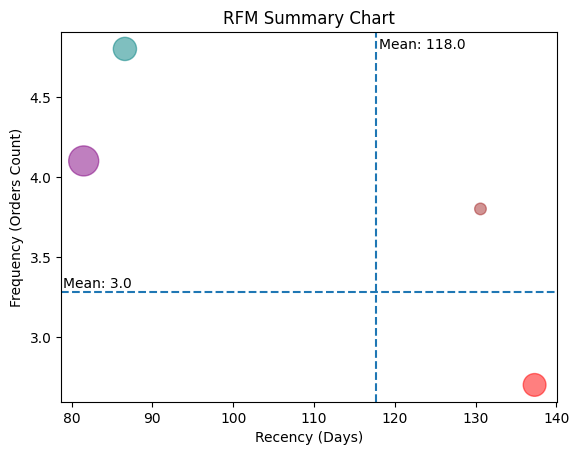

In [250]:
import matplotlib.pyplot as plt

# plt.scatter(data=datamart, x='recency', y='frequency', c='cluster', s='sales_Last_18_M')
# plt.scatter(data=datamart, x='recency', y='frequency', c='cluster')
plt.scatter(
    data=customer_cluster_summary,
    x="Mean_Recency",
    y="Mean_Frequency",
    s="Total_Sales_K",
    c=colors.values(),
    alpha=0.5,
)
plt.title("RFM Summary Chart")
plt.axhline(y=f_line, linestyle="--", label="Mean=" + str(f_line))
plt.axvline(x=r_line, linestyle="--", label="Mean=" + str(r_line))
plt.text(x=79, y=3.31, s="Mean: " + str(round(f_line, 0)))
plt.text(x=118, y=4.8, s="Mean: " + str(round(r_line, 0)))
# plt.legend()
# plt.xlim(0, 150)
# plt.ylim(0, 6)
plt.xlabel("Recency (Days)")
plt.ylabel("Frequency (Orders Count)")
plt.show()

* After we clustered the 753 customers using KMeans, we got the mean of Recency, Frequency and Monetary of each cluster.
The above chart presents the Recency on the x axis, Frequency on the y axis and then the bubble size corresponds to the third element which is Monetary.
* The two crossed blue lines illustrates the means of the R & F
* The two bubbles on the top left area present those classes with a relative high frequency and low recency, they both drive the sales given their bubble sizes are the biggest compared to the others, their details are brokendown below

In [249]:
customer_cluster_summary

,cluster,cluster_color,Mean_Recency,Mean_Frequency,Mean_Monetary,Customer_Count,Total_Sales,Total_Sales_K
0,0,purple,81.5,4.1,2167.7,216,468216.5,468.2
1,1,red,137.3,2.7,560.4,479,268450.4,268.5
2,2,teal,86.6,4.8,5267.7,53,279188.7,279.2
3,3,brown,130.6,3.8,13952.6,5,69763.0,69.8
